<a href="https://colab.research.google.com/github/Monoxido45/Active_learning_tests/blob/master/modules/active_learning_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Exemplos simples de Active learning:** 



*   Primeiramente iremos usar o banco de dados iris, para uma pequena pratica:



In [179]:
# pacotes importados
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

# PCA e os dados de interesse
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

Antes de realizar o active learning para o exemplo do iris, podemos explorar o banco de dados:

In [180]:
# importando o IRIS
iris = load_iris()

# transformando o objeto iris em um data frame pandas
iris_data = pd.DataFrame(data = np.c_[iris['data'], iris['target']],
                         columns = iris['feature_names'] + ['target'])


# vendo apenas as 10 primeiras observacoes
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Primeiramente, podemos fazer uma matriz de gráfico de dispersão

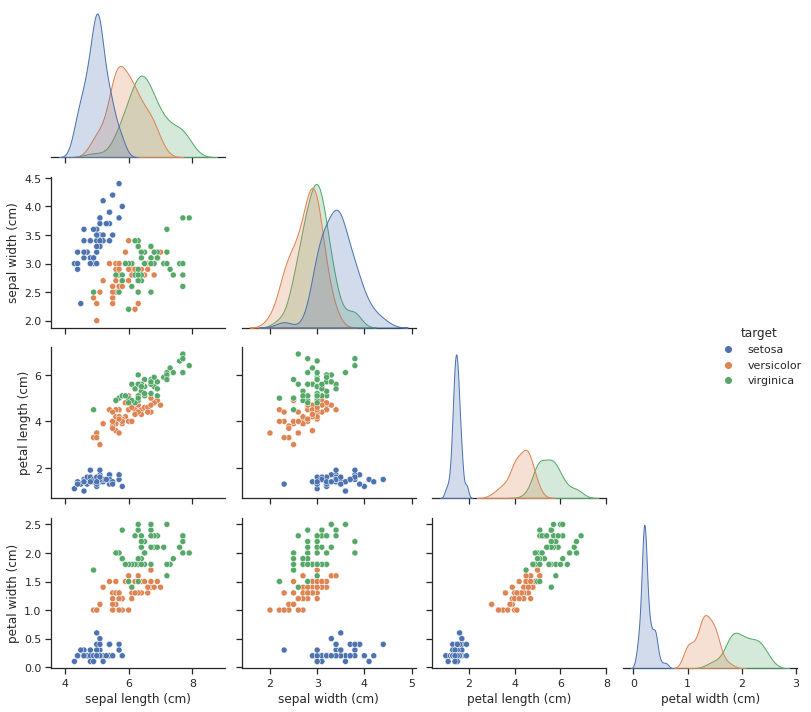

In [181]:
# dados para a analise descritiva
iris_desc = iris_data.copy()

replace_data = {"target" : {0.0: iris['target_names'][0],
                            1.0: iris['target_names'][1],
                            2.0: iris['target_names'][2]}}

iris_desc = iris_desc.replace(replace_data)
sns.set_style("ticks")

sns.pairplot(iris_desc, hue = "target", corner=True)
plt.tight_layout()

Além disso, também podemos fazer uma matriz de correlação:

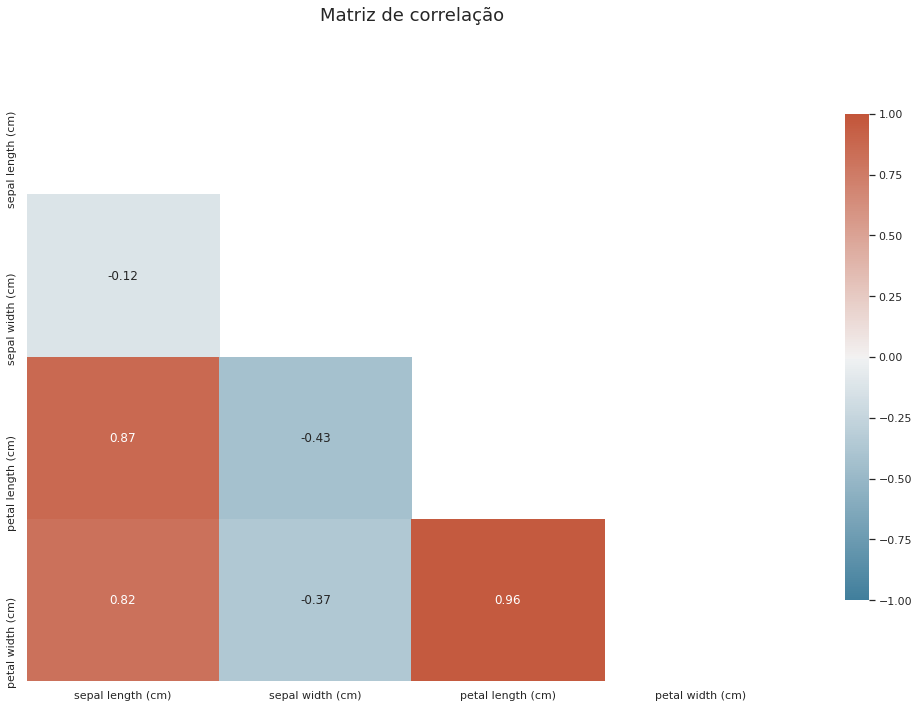

In [182]:
sns.set_theme(style="white")

# fazendo a matriz de correlacao usando mascaras
corr = iris_desc.corr()
mask = np.triu(np.ones_like(corr))

# figura do matplotlib
f, ax = plt.subplots(figsize=(14, 10))

# palheta customizada
cmap = sns.diverging_palette(230, 20, as_cmap = True)

heatmap = sns.heatmap(corr, mask=mask, vmax= 1, vmin = -1, cmap = cmap, cbar_kws={"shrink": .75}, annot = True)
heatmap.set_title('Matriz de correlação', fontdict={'fontsize':18}, pad=12)
plt.tight_layout()

E por fim alguns violinplots separados:

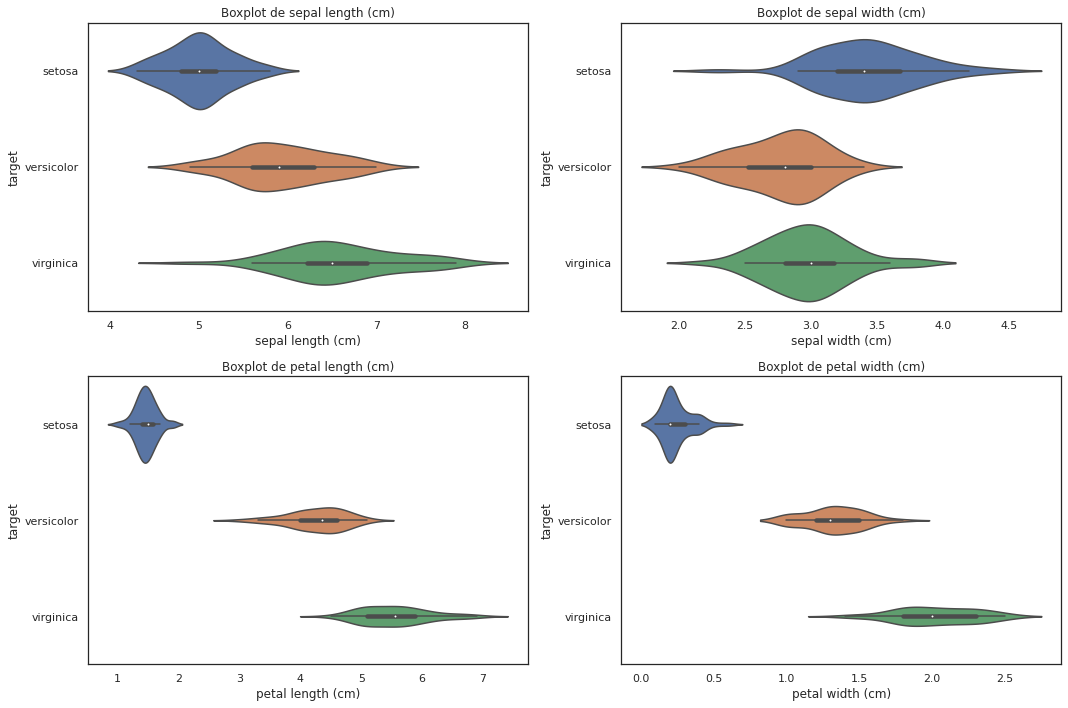

In [183]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))
medidas = iris_desc.columns
for i in range(0,4):
  j = i + 1
  plt.subplot(2,2,j)
  sns.violinplot(x = medidas[i], y = "target", data = iris_desc, orient = "h")
  plt.title("Boxplot de {}".format(medidas[i]))

plt.tight_layout()

Por fim, podemos checar se os níveis da variável target são balanceados a partir de um gráfico de barras:

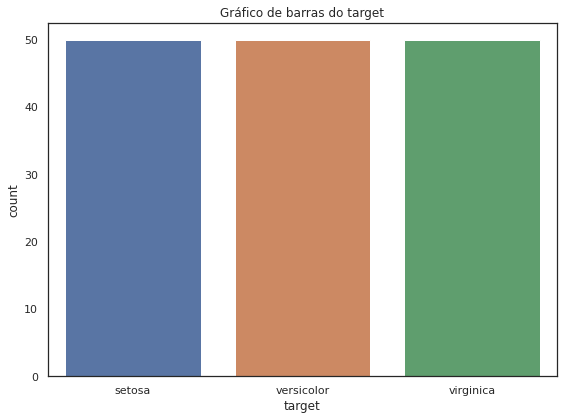

In [184]:
fig, axes = plt.subplots(figsize = (8, 6))
sns.countplot(x = 'target', data = iris_desc)
plt.title("Gráfico de barras do target")
plt.tight_layout()

Parece haver uma igualdade de frequência das diferentes espécies. Assim, vemos pela matriz de correlação alta correlação entre comprimento de sépala e ambas medidas de pétala (comprimento e largura). Além disso, o comprimento de pétala tem alta correlação com a largura. Podemos reduzir a dimensão da matriz de covariaveis ao utilizar uma analise de componentes principais. Isso será interessante para analisar de forma bivariada a performance dos modelos a seguir:

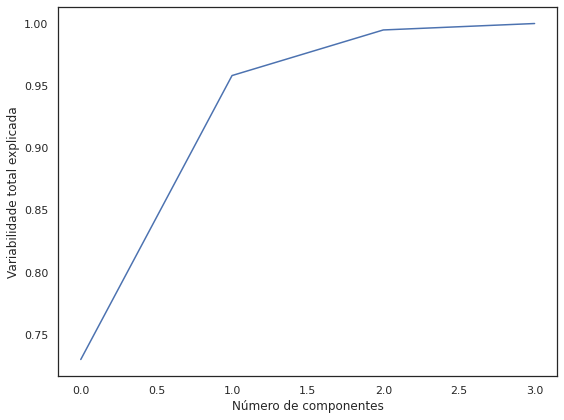

In [185]:
# separando features e target
X = iris_data.iloc[:, 0:4].values
y = iris_data.iloc[:, 4].values

# escalonando os dados
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

# obtendo o PCA com todos os componentes
pca = PCA()
pca_fit = pca.fit(X)
# avaliando a variancia explicada
fig, axes = plt.subplots(figsize = (8, 6))
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel("Número de componentes")
plt.ylabel("Variabilidade total explicada")
plt.tight_layout()

Observa-se que dois componentes de fato são suficientes para a analise, tendo portanto:

In [186]:
pca = PCA(n_components=2)

pcs = pca.fit_transform(X)

pcs[1:10, :]
X = pcs

Obtendo um gráfico de dispersão 2D com os dois componentes principais:

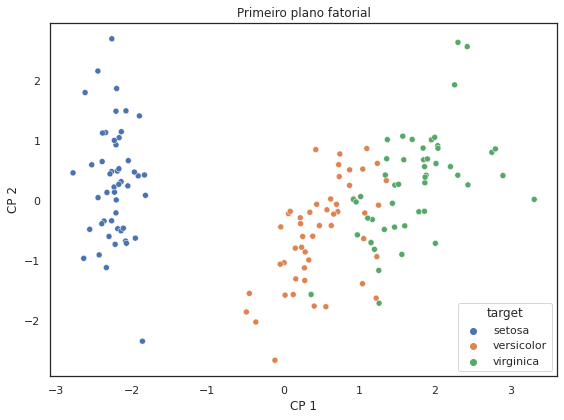

In [187]:
principalDf = pd.DataFrame(data = pcs,
             columns = ['CP 1', 'CP 2'])

principalDf = pd.concat([principalDf, iris_desc[['target']]], axis = 1)

fig, axes = plt.subplots(figsize = (8, 6))
sns.scatterplot(data = principalDf, x = "CP 1", y = "CP 2", hue = "target")
plt.title("Primeiro plano fatorial")
plt.tight_layout()

Podemos então agora, utilizando o pacote modAL para realizar um active learning, utilizando inicialmente a amostragem por incerteza, e posteriormente o queriyng by comitee:

In [218]:
# importando estimadores tanto para amostrar pela incerteza quanto montar o comite
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from modAL import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling

# declarando o learner para o random forest
learner_rf = ActiveLearner(
    estimator = RandomForestClassifier(),
    query_strategy = uncertainty_sampling
)

# declarando o learner para o KNN
learner_knn = ActiveLearner(
    estimator = KNeighborsClassifier(n_neighbors = 5),
    query_strategy = uncertainty_sampling
)

# fixando a semente
seed = 1200
np.random.seed(seed)

# setando as amostras iniciais:
# 5 para treinamento inicial
n_initial = 5
X_pool = np.copy(X)
y_pool = np.copy(y)
train_idx = np.random.choice(range(X_pool.shape[0]), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]

# reduzindo a pool
X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

# tomando uma pool para RF e outra para KNN
X_pool_rf = np.copy(X_pool)
y_pool_rf = np.copy(y_pool)

X_pool_knn = np.copy(X_pool)
y_pool_knn = np.copy(y_pool)

learner_rf.teach(X_train, y_train)
learner_knn.teach(X_train, y_train)

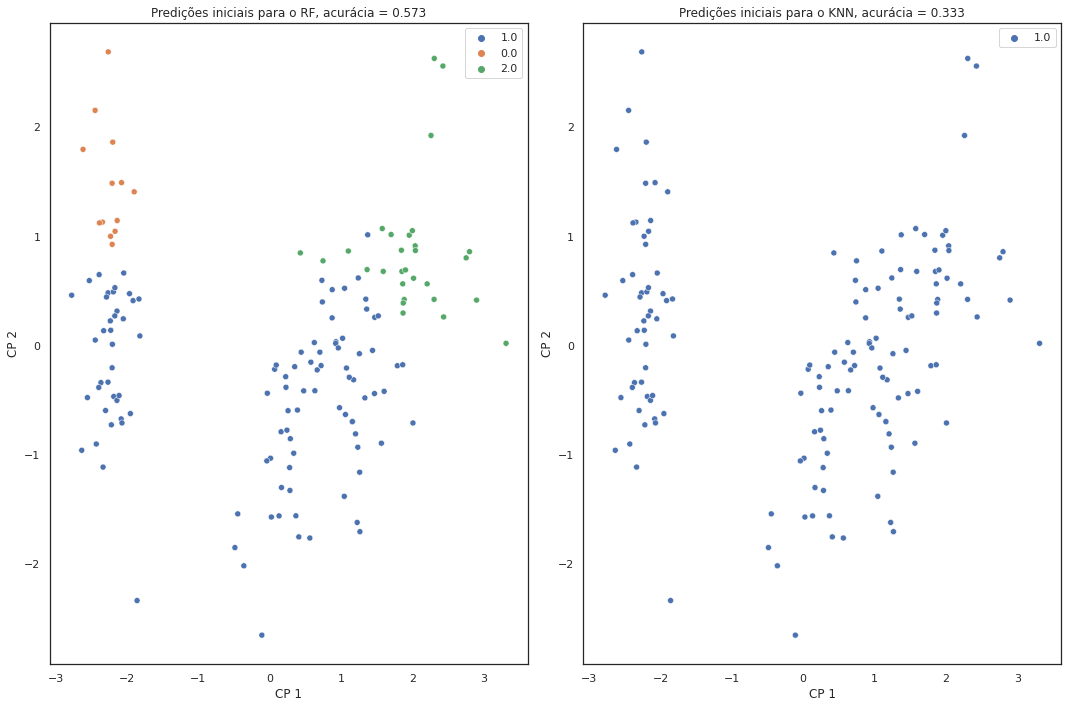

In [220]:
unqueried_score_rf = learner_rf.score(X, y)
unqueried_score_knn = learner_knn.score(X, y)

unqueried_scores = [unqueried_score_rf, unqueried_score_knn]
learners = [learner_rf, learner_knn]
names = ["RF", "KNN"]
plt.figure(figsize = (15, 10))

for i in range(0,2):
  plt.subplot(1, 2, i + 1)
  prediction = learners[i].predict(X)
  sns.scatterplot(data = principalDf, x = "CP 1", y = "CP 2", hue = prediction.astype('str'))
  plt.title("Predições iniciais para o %s, acurácia = %1.3f" % (names[i], unqueried_scores[i]))

plt.tight_layout()

In [221]:
n_queries = 20
performance_history_rf = [unqueried_score_rf]
performance_history_knn = [unqueried_score_knn]


for index in range(n_queries):
  # obtendo o indice para perguntar os labels
  query_index_rf, query_instance_rf = learner_rf.query(X_pool_rf)
  query_index_knn, query_instance_knn = learner_knn.query(X_pool_knn)

  # ensinando o activelearner
  # Random Forest
  X_sel, y_sel = X_pool_rf[query_index_rf].reshape(1, -1), y_pool_rf[query_index_rf].reshape(1, )
  learner_rf.teach(X = X_sel, y = y_sel)
  X_pool_rf, y_pool_rf = np.delete(X_pool_rf, query_index_rf, axis=0), np.delete(y_pool_rf, query_index_rf)
  
  # KNN
  X_sel, y_sel = X_pool_knn[query_index_knn].reshape(1, -1), y_pool_knn[query_index_knn].reshape(1, )
  learner_knn.teach(X = X_sel, y = y_sel)
  X_pool_knn, y_pool_knn = np.delete(X_pool_knn, query_index_knn, axis=0), np.delete(y_pool_knn, query_index_knn)

  # acuracia para cada modelo com a nova observacao
  model_accuracy_rf = learner_rf.score(X, y)
  model_accuracy_knn = learner_knn.score(X, y)
  
  # historico de performance para ambos
  performance_history_rf.append(model_accuracy_rf)
  performance_history_knn.append(model_accuracy_knn)

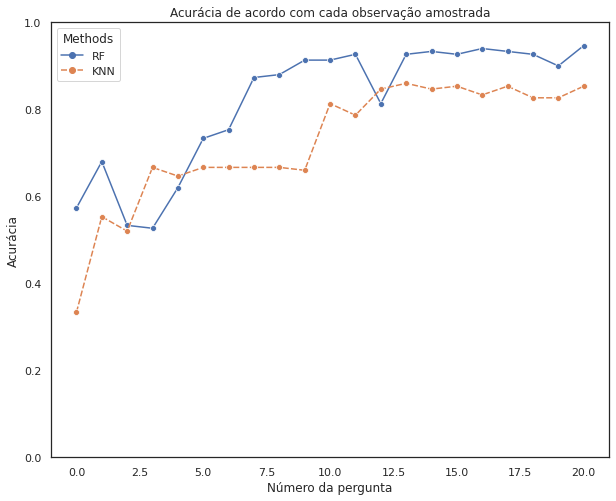

In [222]:
names = ["RF", "KNN"]
plt.figure(figsize = (10, 8))

data = pd.DataFrame(data = {'Acuracia': performance_history_rf + performance_history_knn, 
                            'Query': np.tile(np.arange(0,21), 2),
                            'Methods':np.concatenate((np.full(shape = 21, fill_value = "RF"), 
                                                         np.full(shape = 21, fill_value = "KNN")))})

sns.lineplot(data = data, x = "Query", y = "Acuracia", markers=["o", "o"], hue = "Methods", style="Methods") 
plt.title("Acurácia de acordo com cada observação amostrada")
plt.xlabel("Número da pergunta")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()

In [ ]:
# iniciando o comite
n_members = 2
learner_list = list()

# lista de classificadores sendo usado
classifier_list = ["RandomForestClassifier", "KNeighborsClassifier"]